We have two goals:
    1. Minimize number of echoes discarded
    2. Minimize residuals/maximize TSNR

In [1]:
%matplotlib inline
from glob import glob

import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

from tedana.utils import load_data, make_adaptive_mask
from tedana import utils
#from tedana.model import fit_decay

sns.set_style('whitegrid')

In [2]:
def fit_decay(data, tes, mask, masksum, start_echo=2, get_res=True):
    if len(data.shape) == 3:
        n_samp, n_echos, n_vols = data.shape
    else:
        n_samp, n_echos = data.shape
        n_vols = 1

    n_mask = np.sum(mask)
    data = data[mask]
    t2ss = np.zeros([n_mask, n_echos - (start_echo - 1)])
    s0vs = np.zeros([n_mask, n_echos - (start_echo - 1)])
    
    # Evaluate fit quality
    r2ss = np.zeros([n_mask, n_echos - (start_echo - 1)])
    all_residuals = np.zeros([n_mask, n_echos - (start_echo - 1)])
    n_echos_discarded = np.zeros([n_mask, n_echos - (start_echo - 1)])

    for echo in range(start_echo, n_echos + 1):
        # perform log linear fit of echo times against MR signal
        # make DV matrix: samples x (time series * echos)
        B = np.log((np.abs(data[:, :echo, :]) + 1).reshape(len(data), -1).T)
        # make IV matrix: intercept/TEs x (time series * echos)
        x = np.column_stack([np.ones(echo), [-te for te in tes[:echo]]])
        X = np.repeat(x, n_vols, axis=0)

        temp = np.ones((n_vols*echo, 1))
        _, baseline_res, _, _ = np.linalg.lstsq(temp, B, rcond=None)
        betas, residuals, rank, sing_values = np.linalg.lstsq(X, B, rcond=None)
        r2 = 1 - (residuals / baseline_res)
        t2s = 1. / betas[1, :].T
        s0 = np.exp(betas[0, :]).T

        # t2s[np.isinf(t2s)] = 500.  # why 500?
        # s0[np.isnan(s0)] = 0.      # why 0?

        r2ss[:, echo - start_echo] = np.squeeze(r2)
        t2ss[..., echo - start_echo] = np.squeeze(t2s)
        s0vs[..., echo - start_echo] = np.squeeze(s0)
        all_residuals[:, echo - start_echo] = np.squeeze(residuals)
        n_echos_discarded[:, echo - start_echo] = n_echos - echo
    
    if get_res:
        return all_residuals, n_echos_discarded, t2ss, s0vs, r2ss
    else:
        return betas, residuals, rank, sing_values, X, B

In [3]:
files = sorted(glob('/Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/*.nii.gz'))
tes = [15.4, 29.7, 44.0, 58.3, 72.6]

In [4]:
# Load and mask data
data, ref_img = load_data(files, n_echos=len(tes))
mask, old_masksum = make_adaptive_mask(data, minimum=False, getsum=True)
masksum = mask.copy()
masksum[mask==1] = 5

# Compute TSNR
imgs = [nib.load(f).get_data() for f in files]
mean_data = [np.mean(img, axis=3) for img in imgs]
std_data = [np.std(img, axis=3) for img in imgs]
tsnrs = [mean_data[i] / std_data[i] for i in range(len(imgs))]
tsnr_data = np.stack(tsnrs, axis=-1)
tsnr_data = np.nan_to_num(tsnr_data, 0)
tsnr_data = utils.load_image(tsnr_data)
tsnr_data = tsnr_data[mask, :]

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


In [5]:
# Get residuals for fits to ascending numbers of echoes
all_residuals, n_echos_discarded, t2ss, s0vs, r2s = fit_decay(data, tes, mask, masksum, get_res=True)

# Get betas and residuals for 5-echo fit
betas, residuals, rank, sing_values, X, B = fit_decay(data, tes, mask, masksum, get_res=False)
intercepts = betas[0, :]
slopes = betas[1, :]

In [6]:
# Best fit voxel
voxel_idx = np.where(all_residuals[:, -1] == np.min(all_residuals[:, -1]))
voxel_idx = voxel_idx[0][0]
print(voxel_idx)

19541


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


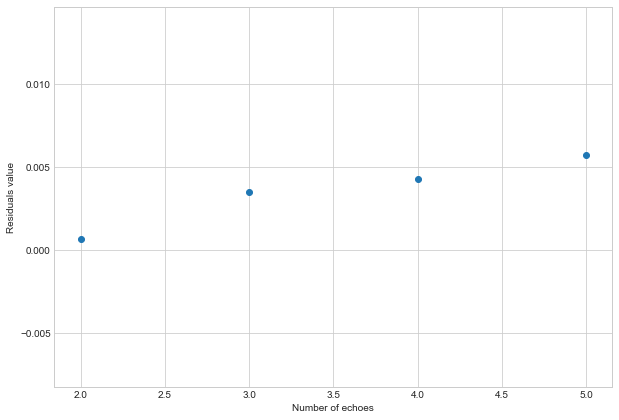

In [7]:
# Plot residuals from ascending echo log-linear fits for best voxel
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(range(2, 6), all_residuals[voxel_idx, :])
ax.set_xlabel('Number of echoes')
ax.set_ylabel('Residuals value')
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


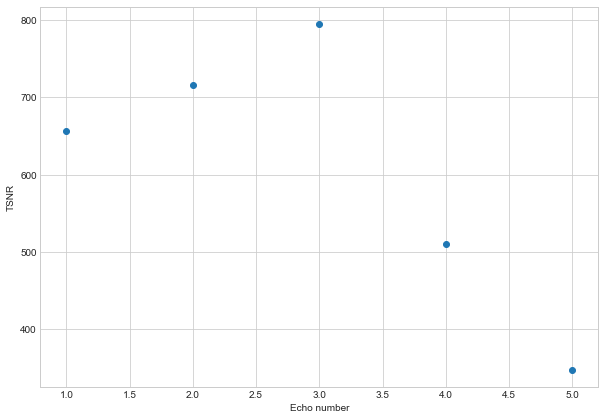

In [8]:
# Plot TSNR for best voxel
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(np.arange(1, 6), tsnr_data[voxel_idx, :])
ax.set_xlabel('Echo number')
ax.set_ylabel('TSNR')
fig.show()

In [9]:
# Get line from log-linear model for best fit voxel
intercept = intercepts[voxel_idx]
slope = slopes[voxel_idx]
x_vals = X[:, 1]
data = B[:, voxel_idx]
min_x, max_x = np.min(x_vals), np.max(x_vals)
min_pred_y = (slope * min_x) + intercept
max_pred_y = (slope * max_x) + intercept

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


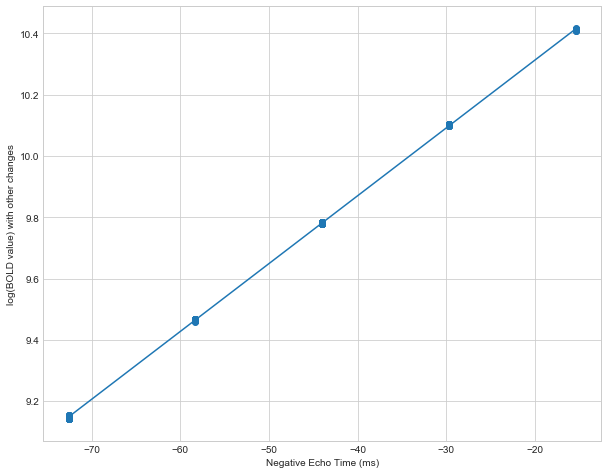

In [10]:
# Plot log-linear model for best fit voxel
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x_vals, data)
ax.set_xlabel('Negative Echo Time (ms)')
ax.set_ylabel('log(BOLD value) with other changes')

ax.plot([min_x, max_x], [min_pred_y, max_pred_y])
fig.show()

In [11]:
# Get worst fit voxel for 5-echo model
voxel_idx = np.where(residuals == np.max(residuals))[0][0]
print(voxel_idx)
intercept = intercepts[voxel_idx]
slope = slopes[voxel_idx]
x_vals = X[:, 1]
data = B[:, voxel_idx]
min_x, max_x = np.min(x_vals), np.max(x_vals)
min_pred_y = (slope * min_x) + intercept
max_pred_y = (slope * max_x) + intercept

10436


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


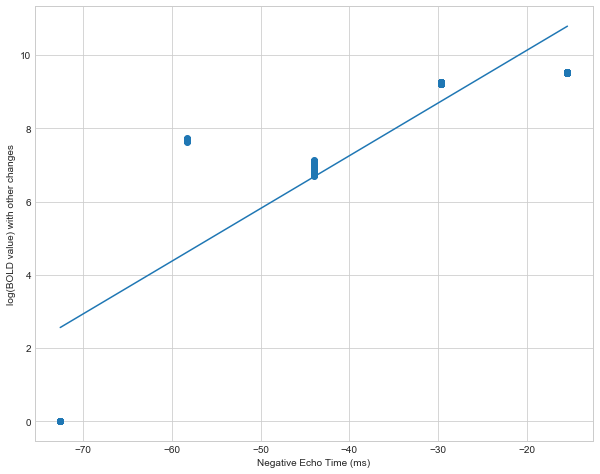

In [12]:
# Plot log-linear model for worst fit voxel
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x_vals, data)
ax.set_xlabel('Negative Echo Time (ms)')
ax.set_ylabel('log(BOLD value) with other changes')

ax.plot([min_x, max_x], [min_pred_y, max_pred_y])
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


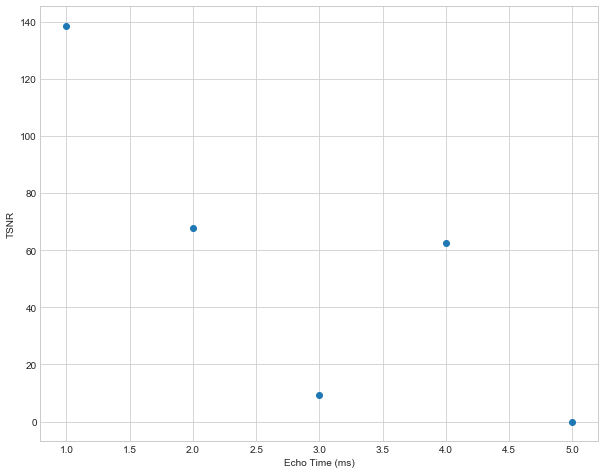

In [13]:
# Plot TSNR for worst fit voxel
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(np.arange(1, 6), tsnr_data[voxel_idx, :])
ax.set_xlabel('Echo Time (ms)')
ax.set_ylabel('TSNR')

fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


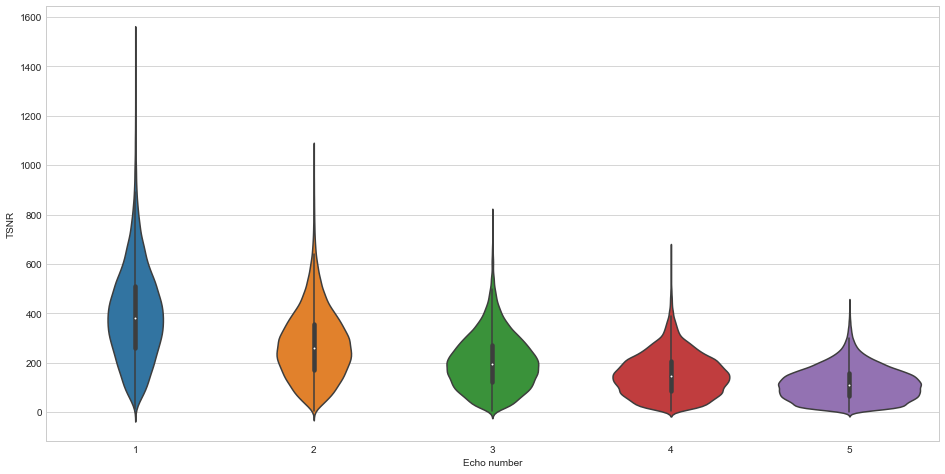

In [14]:
# Plot distributions of TSNR values by echo
fig, ax = plt.subplots(figsize=(16, 8))
n_voxels = tsnr_data.shape[0]
x = np.tile(np.arange(1, 6), (n_voxels, 1))
x = np.ravel(x)
tsnr_data2 = np.ravel(tsnr_data)
#idx = tsnr_data2 != 0
#tsnr_data2 = tsnr_data2[idx]
#x = x[idx]
sns.violinplot(x, tsnr_data2, ax=ax)
ax.set_xlabel('Echo number')
ax.set_ylabel('TSNR')
fig.show()

In [15]:
df = pd.DataFrame(tsnr_data)
df.describe()

,0,1,2,3,4
count,24786.000000,24786.000000,24786.000000,24786.000000,24786.000000
mean,395.503113,273.863739,203.971497,152.677277,115.079628
std,187.963776,139.639572,110.089989,85.087723,66.337990
min,11.064055,3.310591,4.150350,4.309228,0.000000
25%,259.649498,170.936249,121.085442,86.870787,63.468017
50%,382.472656,261.050781,194.213005,145.754189,109.550663
75%,512.201111,358.484390,272.197220,207.078140,157.507671
max,1513.604248,1054.140503,794.495239,658.301880,440.157867


In [16]:
# Use TSNR to create an alternative masksum
def get_tsnr_masksum(tsnr_data, thresh):
    """
    For each voxel, get the highest consecutive echo with TSNR > threshold
    """
    tsnr_over_thresh = tsnr_data > thresh
    tsnr_masksum = np.zeros(tsnr_data.shape[0], int)
    for iv in range(tsnr_data.shape[0]):
        idx_ = np.where(tsnr_over_thresh[iv, :])[0]
        if len(idx_) == 0:
            idx = 0
        else:
            # Get highest consecutive echo with SNR > thresh
            # This is probably totally wrong :)
            if any(np.diff(idx_) != 1):
                idx = np.where(np.diff(idx_)!=1)[0][0]
            else:
                idx = np.max(idx_)+1

        tsnr_masksum[iv] = idx
    return tsnr_masksum

for thresh in np.arange(10, 200, 5):
    tsnr_masksum = get_tsnr_masksum(tsnr_data, thresh)

    r = np.corrcoef(old_masksum[mask], tsnr_masksum)[0, 1]
    print('{0:04d}: {1:0.04f}'.format(thresh, r))

0010: 0.3959
0015: 0.5512
0020: 0.5931
0025: 0.5955
0030: 0.5802
0035: 0.5658
0040: 0.5476
0045: 0.5250
0050: 0.5098
0055: 0.4929
0060: 0.4689
0065: 0.4482
0070: 0.4314
0075: 0.4139
0080: 0.3969
0085: 0.3823
0090: 0.3697
0095: 0.3596
0100: 0.3479
0105: 0.3367
0110: 0.3272
0115: 0.3167
0120: 0.3076
0125: 0.2970
0130: 0.2884
0135: 0.2823
0140: 0.2744
0145: 0.2691
0150: 0.2622
0155: 0.2564
0160: 0.2515
0165: 0.2458
0170: 0.2415
0175: 0.2359
0180: 0.2327
0185: 0.2273
0190: 0.2239
0195: 0.2200


Based on the above, I guess a TSNR threshold of 25 would work best